In [401]:
import json
import operator
from argparse import ArgumentParser
from collections import defaultdict
from functools import reduce
from pathlib import Path
from typing import List, Iterable, Any, Dict
import pandas as pd

from veniq.ast_framework import AST, ASTNodeType, ASTNode
from javalang.parse import parse
from javalang.parser import JavaSyntaxError
from veniq.metrics.ncss.ncss import NCSSMetric
from program_slicing.decomposition.block_slicing import build_opportunities
from program_slicing.decomposition.program_slice import ProgramSlice
from program_slicing.decomposition.block_slicing import build_opportunities_filtered
from program_slicing.decomposition.program_slice import ProgramSlice
from program_slicing.decomposition.program_slice import ProgramSlice
from program_slicing.decomposition.slice_predicate import SlicePredicate
from program_slicing.graph.manager import ProgramGraphsManager
from program_slicing.graph.statement import Statement, StatementType
from program_slicing.graph.point import Point
from sortedcontainers import SortedDict
from program_slicing.graph.parse import LANG_JAVA
from sortedcontainers import SortedDict
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from collections import Counter

IGNORE_USERS = {"zorchenkov.alexey@huawei.com", "zhyryk2021@rambler.ru", "cylyavaivai@gmail.com", "chizhyk2pyzhik@mail.ru"}
java_dir = Path(r'D:\git\program_slicing2\program_slicing\decomposition\files_iter2\java_files')
json_path = Path(r'D:\git\program_slicing2\program_slicing\decomposition\files_iter2\current_batch.json')

In [153]:
def get_web_configs():
    d = Path(r'D:\\git\\program_slicing2\\program_slicing\\decomposition\\files_iter2')
    small_config_filepath = d / 'web_config/small_config.json'
    large_config_filepath = d / 'web_config/large_config.json'
    with open(small_config_filepath) as f:
        small_config = json.loads(f.read())
    with open(large_config_filepath) as f:
        large_config = json.loads(f.read())

    return small_config, large_config

In [154]:
def get_all_methods_config(
        config: Dict[str, Any],
        max_answers_percentage=0.8):

    methods_dict = defaultdict(list)
   
    for x in all_configs:
        methods_dict[x['method_id']].append(x)
    return methods_dict
small_config, large_config = get_web_configs()
all_configs = large_config + small_config
all_methods_config = get_all_methods_config(all_configs)

In [155]:
def get_all_answers_dict(json_path):
    answers_by_users = {}
    with open(json_path) as f:
        answers = json.loads(f.read())
        
        for x in answers.get('data').get('listAnswers').get('items'):
            if x['user'] not in IGNORE_USERS:
                user_dict = answers_by_users.get(x['user'])
                if user_dict:
                    answers_by_method_id = user_dict.get(x['method'])
                    if answers_by_method_id:
                        sample_id = answers_by_method_id.get(x['question'])
                        if sample_id:
                            sample_id.append(x)
                        else:
                            answers_by_method_id[x['question']] = [x]
                    else:
                        user_dict[x['method']] = {x['question']: [x]}
                else:
                    answers_by_users[x['user']] = {x['method']: {x['question']: [x]}}
                
    return answers_by_users
all_answers_dict = get_all_answers_dict(json_path)

In [167]:
def filter_answers(all_answers_dict, all_methods_config, max_diff_ids=3):
    
    filtered_answers = defaultdict(list)
    for user, methods_dict in all_answers_dict.items():
#         print(user)
        for method_id, questions_dict in methods_dict.items():
            print(user, method_id)
            config_answers = {x['sample_id'] for x in all_methods_config[method_id]}
#             print(config_answers)
            user_answers = set(questions_dict.keys())
            diff = config_answers.difference(user_answers)
            if len(diff) <= max_diff_ids:
                filtered_answers[method_id].extend(questions_dict.values())
               
    new_filtered_answers = {}
    for method_id, vals in filtered_answers.items():
        new_vals = reduce(operator.concat, vals)
        new_filtered_answers[method_id] = new_vals
    return new_filtered_answers

filtered_answers = filter_answers(all_answers_dict, all_methods_config)
filtered_answers

websprogrammer@gmail.com method_16.java
websprogrammer@gmail.com method_14.java
websprogrammer@gmail.com method_12.java
websprogrammer@gmail.com method_19.java
websprogrammer@gmail.com method_18.java
websprogrammer@gmail.com method_8.java
websprogrammer@gmail.com method_10.java
websprogrammer@gmail.com method_15.java
websprogrammer@gmail.com method_17.java
websprogrammer@gmail.com method_13.java
websprogrammer@gmail.com method_11.java
andrei.tatarnikov@huawei.com method_8.java
andrei.tatarnikov@huawei.com method_3.java
andrei.tatarnikov@huawei.com method_5.java
andrei.tatarnikov@huawei.com method_1.java
andrei.tatarnikov@huawei.com method_0.java
andrei.tatarnikov@huawei.com method_9.java
andrei.tatarnikov@huawei.com method_4.java
andrei.tatarnikov@huawei.com method_6.java
andrei.tatarnikov@huawei.com method_7.java
andrei.tatarnikov@huawei.com method_2.java
wanghaitao6@huawei.com method_12.java
wanghaitao6@huawei.com method_11.java
wanghaitao6@huawei.com method_19.java
wanghaitao6@huawe

{'method_16.java': [{'id': 'f41f8ec3-270f-41bd-8545-b3b859032aaa',
   'question': 163,
   'answer': 'yes',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T10:41:45.467Z',
   'updatedAt': '2021-06-23T10:41:45.467Z'},
  {'id': '6ae29e6e-7da1-46a2-aee2-3e33e44009c2',
   'question': 160,
   'answer': 'no',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T09:51:08.010Z',
   'updatedAt': '2021-06-23T09:51:08.010Z'},
  {'id': '6f49ea04-8e4f-4a04-890a-420717dd37d5',
   'question': 161,
   'answer': 'yes',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T10:34:06.210Z',
   'updatedAt': '2021-06-23T10:34:06.210Z'},
  {'id': '7a7d8385-8368-4c9d-a388-9f9ada5b5524',
   'question': 164,
   'answer': 'no',
   'user': 'websprogrammer@gmail.com',
   'method': 'method_16.java',
   'createdAt': '2021-06-23T10:21:48.887Z',
   'updatedAt': '2021-06-23T10:21:48.

In [238]:
#all_methods_config

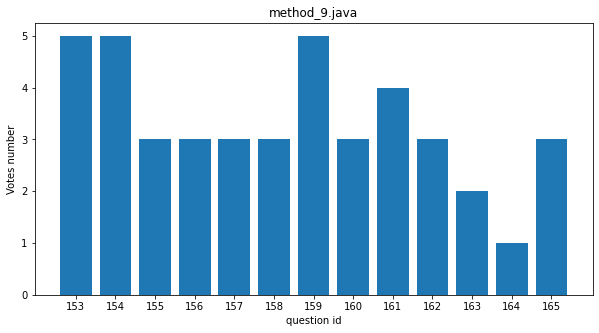

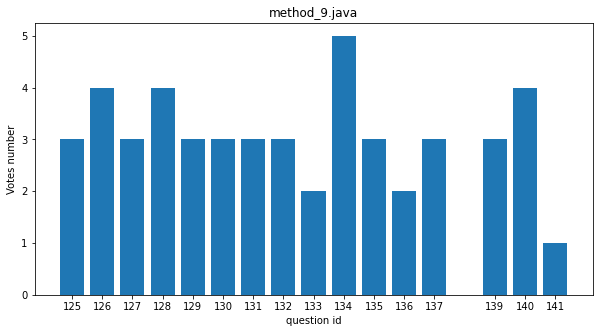

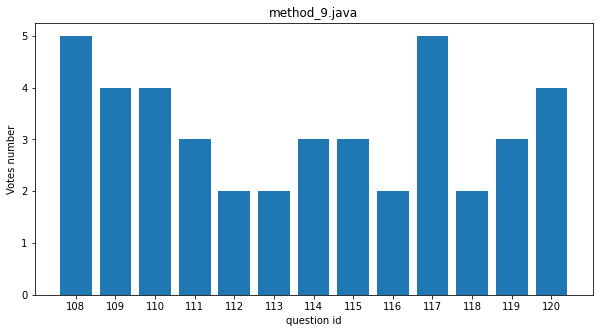

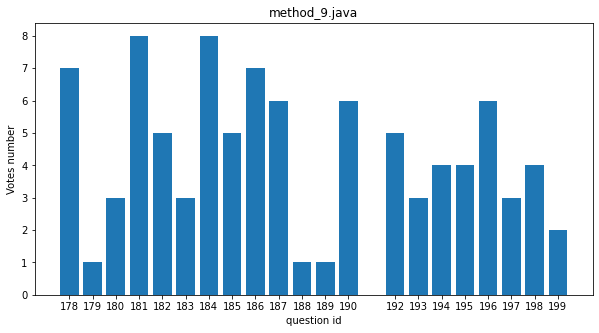

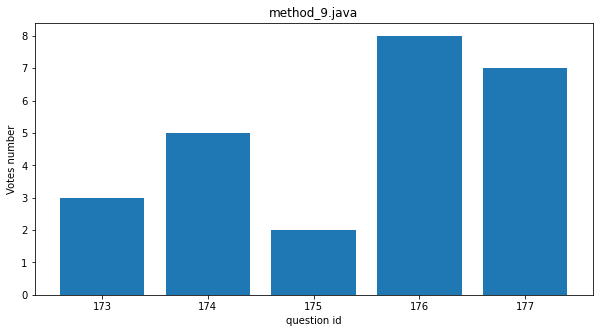

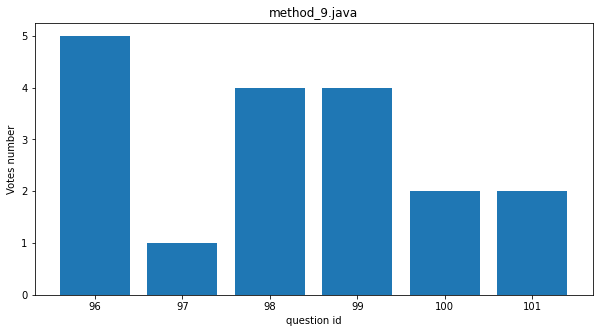

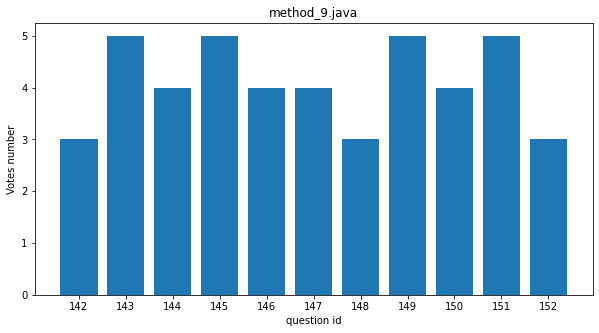

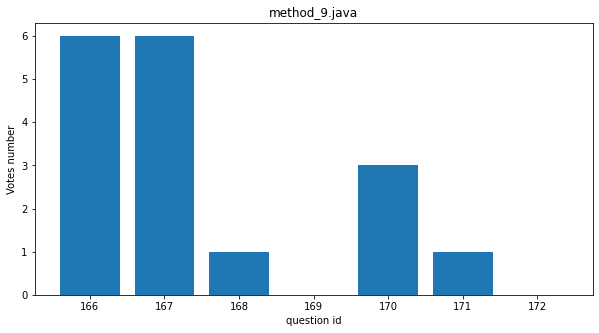

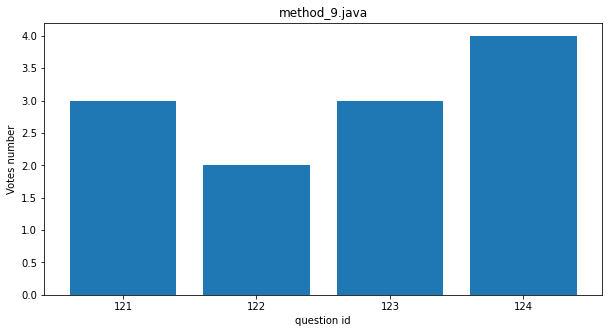

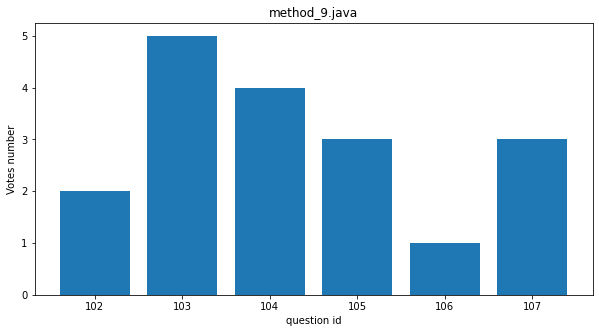

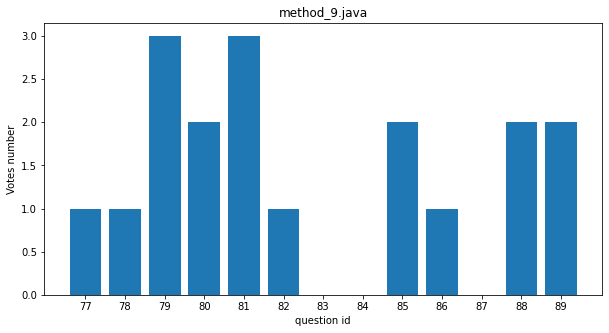

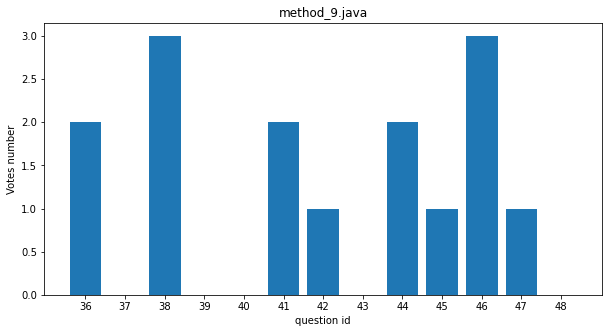

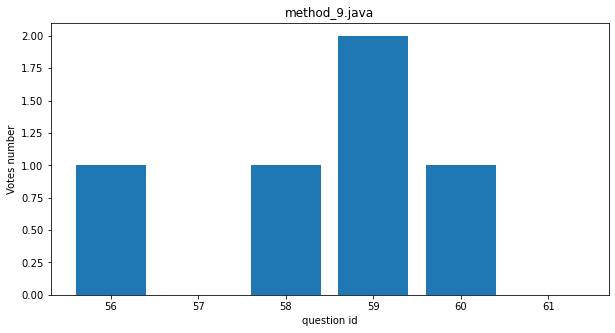

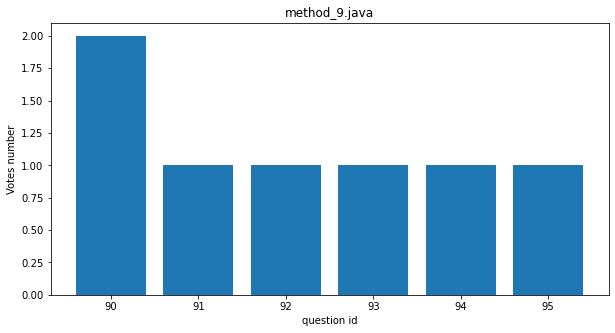

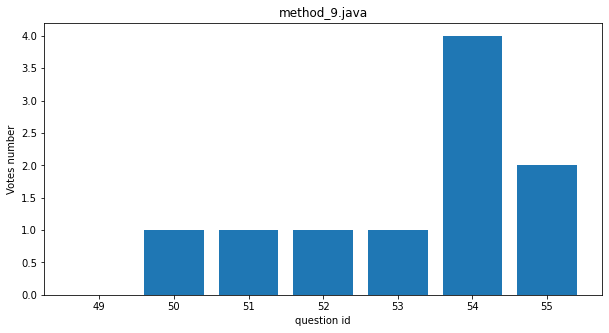

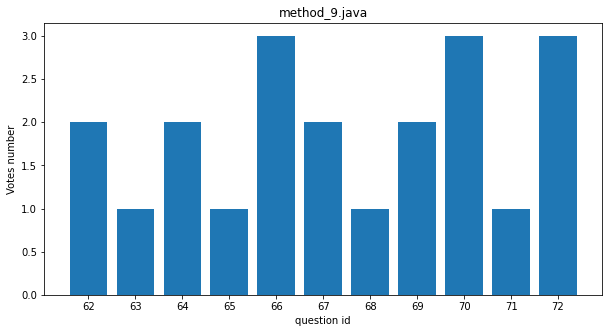

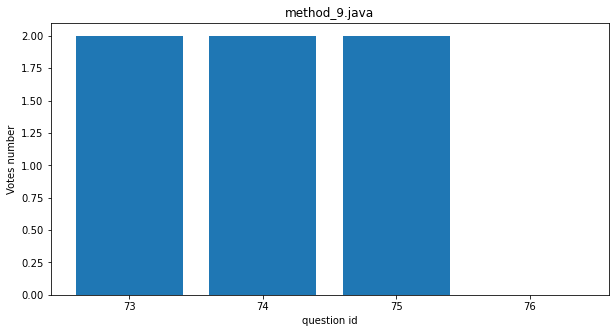

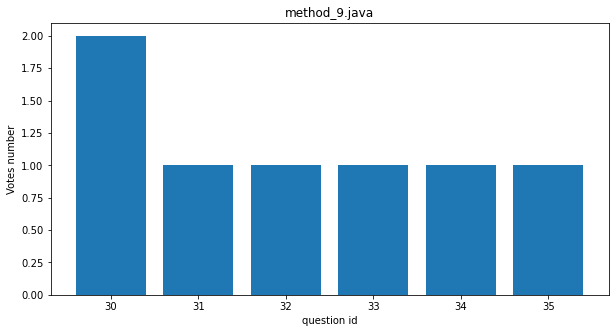

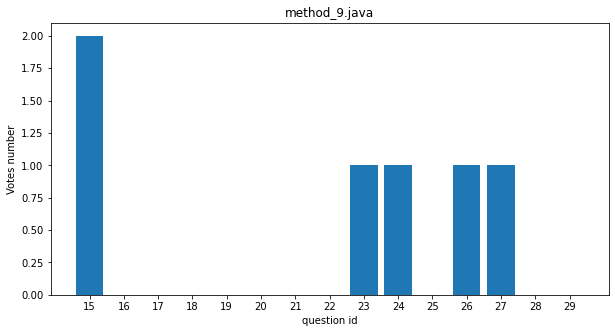

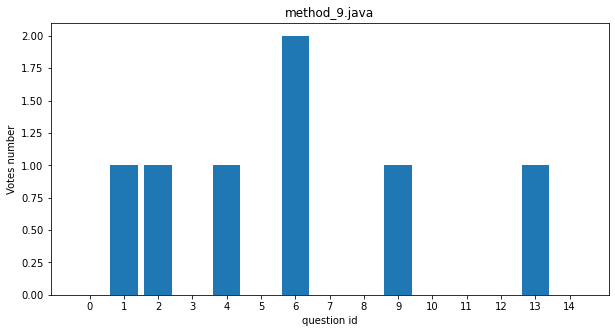

In [264]:
def show_bars(vals):
    plt.rcParams["figure.figsize"] = (10,5)
    plt.bar([int(x) for x in vals.keys()], [int(x) for x in vals.values()])
    plt.title(method_id)
    plt.xticks([int(x) for x in vals.keys()])
    plt.xlabel('question id')
    plt.ylabel('Votes number')
    plt.show()
    


def find_not_answered_questions(filtered_answers):
    ans_yes = defaultdict(list)
#     ans_no = defaultdict(list)
    for method_id, answers in filtered_answers.items():
        for x in answers:
            if x['answer'] == "yes":
                ans_yes[method_id].append(x['question'])
    #         else:
    #             ans_no[method_id].append(['question']})

    all_vals = {}
    for method_id, answers in ans_yes.items():
    #     ans = reduce(operator.concat, [list(x.values()) for x in answers])
        answered = set(ans_yes[method_id])
        config_items = {x['sample_id'] for x in all_methods_config.get(method_id)}
    #     print(method_id, config_items)
        # find which answers were no or were not answered at all  
        missed = config_items.difference(answered)
        missed_dict = {}
        if missed:
            missed_dict = {x: 0 for x in missed}
    #         print('Missed ', method_id, missed_dict)
        vals = {**Counter(answers), **missed_dict}
        not_answered_by_users = {x for x, y in vals.items() if y == 0}
        if not_answered_by_users:
            all_vals[method_id] = not_answered_by_users
    #     print(method_id, vals)
        show_bars(vals)
    
    return all_vals

not_answered = find_not_answered_questions(filtered_answers)

In [355]:
print('not_answered: ', not_answered)

def print_debug_code(start, end, code):
    print('####################################################')
    print(start, end)
    print(code)
    print('####################################################3')

def get_non_filtered_slices(all_methods_config, not_answered):
    slices = defaultdict(list)
    for method_id, d in all_methods_config.items():
    #     method_id = 'method_0.java'
        not_answered_q = not_answered.get(method_id)
        if not_answered_q:
            with open(java_dir / method_id) as f:
                code = f.read()
            htmls = [x['html'] for x in d if x['sample_id'] in not_answered_q]
#             print(method_id)
            not_answered_lines = set()
            for html in htmls:
                string_parsed = html.split(Path(method_id).stem)[1].split('.')[0].split('_')[1:3]
                start = int(string_parsed[0])
                end = int(string_parsed[1])
                not_answered_lines.add((start, end))
    #             code = '\n'.join(code_lines[start - 1:end])
    #             print_debug_code(code)
#             print(not_answered_lines)
            found_opportunities = {
                program_slice
                for program_slice in build_opportunities_filtered(
                  code, LANG_JAVA, min_amount_of_lines=6, max_percentage_of_lines=0.8) 
                if (program_slice.ranges[0][0].line_number + 1, program_slice.ranges[-1][1].line_number + 1) in not_answered_lines
            }
#             opporunitites_currently_not_ignored = not_answered_lines.intersection(found_opportunities)
            if found_opportunities:
                slices[method_id].extend(found_opportunities)
            
    for method_id, slc in slices.items():
        set_lines = {(x.ranges[0][0].line_number + 1, x.ranges[-1][1].line_number + 1) for x in slc}
        print(f'EMOs are not ignored: {method_id} {set_lines}')
        
    return slices
    #         print(f'EMOs to ignore: {not_answered_lines}')

non_filtered_slices = get_non_filtered_slices(all_methods_config, not_answered)      

not_answered:  {'method_17.java': {169, 172}, 'method_8.java': {83, 84, 87}, 'method_3.java': {37, 39, 40, 43, 48}, 'method_5.java': {57, 61}, 'method_4.java': {49}, 'method_7.java': {76}, 'method_1.java': {16, 17, 18, 19, 20, 21, 22, 25, 28, 29}, 'method_0.java': {0, 3, 5, 7, 8, 10, 11, 12, 14}}
EMOs are not ignored: method_17.java {(56, 67), (49, 62)}
EMOs are not ignored: method_0.java {(23, 42), (24, 36), (24, 35), (26, 32), (3, 9), (21, 40), (23, 40), (24, 34), (19, 40)}
EMOs are not ignored: method_1.java {(20, 30), (7, 16), (9, 15), (5, 16), (20, 28)}
EMOs are not ignored: method_3.java {(8, 32), (11, 32), (25, 32), (12, 26)}
EMOs are not ignored: method_4.java {(4, 22)}
EMOs are not ignored: method_5.java {(11, 17)}
EMOs are not ignored: method_7.java {(23, 29)}
EMOs are not ignored: method_8.java {(43, 55), (21, 55), (20, 55)}


In [492]:
all_methods_config

defaultdict(list,
            {'method_10.java': [{'sample_id': 96,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_22_37.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 97,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_23_32.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 98,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_23_36.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 99,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_24_32.html',
               'has_true_emo': False,
               'group': 'large'},
              {'sample_id': 100,
               'method_id': 'method_10.java',
               'html': 'examples/method_10_24_36.html',
     

In [563]:
def count_main_statements(block_slice: ProgramSlice):
    start_line = block_slice.ranges[0][0].line_number
    end_line = block_slice.ranges[-1][1].line_number
    code = str(block_slice)
    print(code)
    manager = ProgramGraphsManager(code, LANG_JAVA)
    ddg = manager.get_data_dependence_graph()
    statements_for_slice = [(x.ast_node_type, x.start_point.line_number + 1, x.end_point.line_number + 1) 
        for x in ddg if x.ast_node_type in ['expression_statement', 'variable_declarator']
    ]
    print(statements_for_slice)
    return len(statements_for_slice)

def count_main_statements_by_comma_delimiter(block_slice: ProgramSlice, method_id):
    start_line = block_slice.ranges[0][0].line_number
    end_line = block_slice.ranges[-1][1].line_number
#     print(method_id, start_line + 1, end_line + 1)
#     code = reduce(operator.add, [x.count(';') for x in str(block_slice).splitlines() if x.count(';') > 0])
    code = [(x.count(';'), x) for x in str(block_slice).splitlines() if x.count(';') > 0]
#     print(block_slice)
    return len(code)
#     return code
    
def count_lines_and_statements(slices, java_dir, not_answered):
    results = []
    for method_id, list_of_slices in slices.items():
#         print(method_id)
#         with open(java_dir / method_id) as f:
#             source_code = f.read()
#             source_lines = source_code.split("\n")
#             full_manager = ProgramGraphsManager(source_code, LANG_JAVA)
#             full_ddg = full_manager.get_data_dependence_graph()
#             a = []
#             for x in full_ddg:
#                 a.append((x.start_point.line_number + 1, x.ast_node_type))
            #print(sorted(a, key=lambda x: x[0]))
        for item in list_of_slices:
            block_slice = item[0]
            sample_id = item[1]
            start_line = block_slice.ranges[0][0].line_number
            end_line = block_slice.ranges[-1][1].line_number
            fake_function = f'''class Foo {{\n public void function() {{ \n\t{str(block_slice)}\n }}\n}}'''
#                 print(fake_function)
            try:
                ast = AST.build_from_javalang(parse(fake_function))
                m_decl = [node for node in ast.get_proxy_nodes(ASTNodeType.METHOD_DECLARATION)][0]
#                     print(m_decl.name)
                ncss = NCSSMetric().value(ast.get_subtree(m_decl))
                vars_total = {node.member for node in ast.get_subtree(m_decl).get_proxy_nodes(ASTNodeType.MEMBER_REFERENCE)}
#                 print(method_id, vars_total, start_line, end_line)
                var_usage = len(vars_total)
            except Exception as e:
                print(e)
                ncss = -1
                var_usage = -1
#                 statements_for_slice = count_main_statements(block_slice)
            statements_for_slice = count_main_statements_by_comma_delimiter(block_slice, method_id)
#             print(dir(block_slice))
#             print(method_id, sample_id, )
            answers_witout_votes_by_method_id = not_answered.get(method_id)
            if answers_witout_votes_by_method_id:
                if sample_id in answers_witout_votes_by_method_id:
                    were_missed = 0
                else:
                    were_missed = 1
            else:
                were_missed = 1
            row = {
                'method_id': method_id, 'start_line': start_line + 1, 
                'end_line': end_line + 1, 'main_st_number': statements_for_slice, 
                'ncss': ncss, 'var_usage': var_usage, 'sample_id': sample_id, 'were_missed': were_missed}

            results.append(row)
#                     print(statements_for_slice)
    return results
                

# print(non_filtered_slices)


def parse_config_slices(config):
    slices = defaultdict(list)
#     samples = []
    for method_id, answers in config.items():
        filepath = java_dir / method_id
        #             print(method_id)
        with open(filepath) as f:
            source_code = f.read()
            source_lines = source_code.split('\n')
            manager = ProgramGraphsManager(source_code, LANG_JAVA)
            ddg = manager.get_data_dependence_graph() 
            
            for ans in answers:
                html = ans['html']
                string_parsed = html.split(Path(method_id).stem)[1].split('.')[0].split('_')[1:3]
                start = int(string_parsed[0]) - 1
                end = int(string_parsed[1]) - 1

                stats = [x for x in ddg if (x.start_point.line_number >= start) and (x.end_point.line_number <= end)]
                slice_t = ProgramSlice(source_lines).from_statements(stats)
#                 print(dir(slice_t))
#                 print(method_id, start + 1, end + 1)
#                 print('#######################')
#                 print(slice_t)
#                 print('#######################')
                slices[method_id].append((slice_t, ans['sample_id']))
#                 samples.append(ans['sample_id'])
        #         print(answers)
    return slices

slices = parse_config_slices(all_methods_config)
dict_with_main_st = count_lines_and_statements(slices, java_dir, not_answered)
dict_with_main_st
# print(all_slices_for_config)

[{'method_id': 'method_10.java',
  'start_line': 22,
  'end_line': 37,
  'main_st_number': 8,
  'ncss': 13,
  'var_usage': 11,
  'sample_id': 96,
  'were_missed': 1},
 {'method_id': 'method_10.java',
  'start_line': 23,
  'end_line': 32,
  'main_st_number': 5,
  'ncss': 8,
  'var_usage': 10,
  'sample_id': 97,
  'were_missed': 1},
 {'method_id': 'method_10.java',
  'start_line': 23,
  'end_line': 36,
  'main_st_number': 7,
  'ncss': 12,
  'var_usage': 10,
  'sample_id': 98,
  'were_missed': 1},
 {'method_id': 'method_10.java',
  'start_line': 24,
  'end_line': 32,
  'main_st_number': 4,
  'ncss': 7,
  'var_usage': 8,
  'sample_id': 99,
  'were_missed': 1},
 {'method_id': 'method_10.java',
  'start_line': 24,
  'end_line': 36,
  'main_st_number': 6,
  'ncss': 11,
  'var_usage': 8,
  'sample_id': 100,
  'were_missed': 1},
 {'method_id': 'method_10.java',
  'start_line': 25,
  'end_line': 31,
  'main_st_number': 3,
  'ncss': 6,
  'var_usage': 6,
  'sample_id': 101,
  'were_missed': 1},
 {

In [571]:
pd.set_option('display.max_rows', 500)
df = pd.DataFrame(columns=['method_id', 'start_line', 'end_line', 'main_st_number', 'ncss', 'var_usage', 'were_missed'])
for x in dict_with_main_st:
    df = df.append(x, ignore_index=True)
df = df.set_index('sample_id')
df.to_csv('train.csv')
df

,method_id,start_line,end_line,main_st_number,ncss,var_usage,were_missed
sample_id,,,,,,,
96.0,method_10.java,22,37,8,13,11,1
97.0,method_10.java,23,32,5,8,10,1
98.0,method_10.java,23,36,7,12,10,1
99.0,method_10.java,24,32,4,7,8,1
100.0,method_10.java,24,36,6,11,8,1
101.0,method_10.java,25,31,3,6,6,1
102.0,method_11.java,41,47,2,5,3,1
103.0,method_11.java,59,73,4,9,4,1
104.0,method_11.java,60,72,4,8,4,1


In [568]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
# df_train = pd.read_csv('train_features.csv')
# df_test = pd.read_csv('test_features.csv')
# train_labels = pd.read_csv('train_labels.csv')
# df_train.head()

NameError: name 'RandomForestClassifier' is not defined